In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import itertools
import h5py
import os

In [3]:
f = h5py.File('../../Data/data_109.h5', 'r')
f.keys()
#f['Sequence'].keys()
f['Sequence']['0'].keys()


<KeysViewHDF5 ['Detections', 'Image', 'Points', 'Security', 'Tracks']>

In [5]:
world2cam_matrix = np.asarray(f['TMatrixWorldToCam'])

In [6]:
proj_matrix = np.asarray(f['ProjectionMatrix'])

In [7]:
#Choose an instant
frame = f['Sequence']['550']

In [8]:
# Detections
np.asarray(frame['Detections'])

array([(( 7.55826022,  3.57378601, -0.99389946),  1.21998942, 0.4030908 , 0.40533212,  1.08830571),
       ((10.17639735, 10.44774544, -1.71636972),  3.6052146 , 0.60883951, 2.38736677,  1.42697215),
       ((-4.40144449, 16.27115881, -1.51588816),  9.49265671, 3.0030787 , 2.85435152,  0.58771908),
       (( 3.94618286, 21.83495282, -1.96743237), 14.00305843, 5.27806664, 4.16327715, -1.45133531),
       ((10.03358399, 26.15501471, -2.1961882 ),  1.85216558, 0.13569586, 0.63933843, -1.56516504),
       (( 8.10925534, 26.11400106, -0.83937308),  0.90969634, 0.37443504, 1.2053839 , -0.56100744)],
      dtype=[('Pos', [('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]), ('Length', '<f8'), ('Width', '<f8'), ('Height', '<f8'), ('Angle', '<f8')])

In [9]:
# Tracks
np.asarray(frame['Tracks'])

array([(838, ( 8.1252339 , 26.11612908, -0.84547427), (3.73683596e-01,  1.33486097, -0.02334995),  4, 2),
       (856, (-4.50888038, 16.17455768, -1.48866309), (6.54153764e-01,  0.99479739, -0.06988981), 18, 2),
       (875, ( 3.90060055, 21.88529747, -1.95968903), (3.43549924e-01, -2.39543843,  0.04847332), 34, 2),
       (887, ( 9.85324908, 10.57094207, -1.49640688), (2.79811472e+00, -1.1188412 , -0.01862386), 34, 2),
       (890, (10.03316283, 26.15637642, -2.19481263), (6.96849681e-04, -0.08784471,  0.00198266),  0, 1)],
      dtype=[('TrackId', '<i8'), ('Pos', [('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]), ('Vel', [('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]), ('ClassId', '<u4'), ('Status', '<i4')])

In [10]:
### Visualize Frame

def convert_to_image_space ( coordinates , world2cam , cam2im ):
    """ Input single set of coordinatetes """
    coord_4 = np.ones (4)
    coord_4[0:3] = coordinates
    cams_coord = ( np.matmul( world2cam , coord_4.T )).T
    cams_coord_4 = np.ones(4)
    
    cams_coord_4 [0:3] = cams_coord [0:3]
    ims_coord = ( np . matmul ( cam2im , cams_coord_4 .T )). T
    # Divide by z coordinate for some reason
    ims_coord [0] = ims_coord [0]/ ims_coord [2]
    ims_coord [1] = ims_coord [1]/ ims_coord [2]
    ims_coord = ims_coord [0:2]
    
    return ( ims_coord )


def visualize_frame_detections ( camera, frame_idx, figsize = None ):
    """ Input camera file and frame index """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])

    x_list = []
    y_list = []

    for point in detected_points:
    
        world_pos = np.array(point[0].tolist())
        fin_pos = convert_to_image_space(world_pos, camera['TMatrixWorldToCam'], camera['ProjectionMatrix'])
        x_list.append(fin_pos[0])
        y_list.append(fin_pos[1])

    # Show image
    a = np.asarray(frame['Image'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    plt.imshow(a, cmap = 'gist_gray', zorder = 1)
    plt.scatter(x_list, y_list, s = 100, color = 'hotpink', zorder = 3)
    
    return

def visualize_frame_boxes ( camera, frame_idx, figsize = None):
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    
    for point in detected_points:
        
        unrotated_vertex1 = np.array([+ point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex2 = np.array([+ point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex3 = np.array([+ point['Length']/2, - point['Width']/2, + point['Height']/2])
        unrotated_vertex4 = np.array([+ point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex5 = np.array([- point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex6 = np.array([- point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex7 = np.array([- point['Length']/2, - point['Width']/2, + point['Height']/2])
        unrotated_vertex8 = np.array([- point['Length']/2, - point['Width']/2, - point['Height']/2])
        
        unrotated_vertex_list = [unrotated_vertex1, unrotated_vertex2, unrotated_vertex3, 
                                 unrotated_vertex4, unrotated_vertex5, unrotated_vertex6, 
                                 unrotated_vertex7, unrotated_vertex8]
        
        rotation_matrix = np.array([[np.cos(point['Angle']), -np.sin(point['Angle']), 0], 
                            [np.sin(point['Angle']), np.cos(point['Angle']), 0], 
                            [0,0,1]])
        
        rotated_vertex_list = np.array([rotation_matrix.dot(v) for v in unrotated_vertex_list])
        rotated_vertex_list = rotated_vertex_list + np.array([point['Pos']['X'], point['Pos']['Y'], point['Pos']['Z']])
        
        vertex_im_list = [convert_to_image_space(v, camera['TMatrixWorldToCam'], camera['ProjectionMatrix']) for v in rotated_vertex_list]
        all_l_list = itertools.combinations(vertex_im_list, 2)

        for i in all_l_list:
            vertex_x_list = [v[0] for v in i]
            vertex_y_list = [v[1] for v in i]
            plt.plot(vertex_x_list, vertex_y_list, color = 'b', zorder = 2)
        
    visualize_frame_detections ( camera, frame_idx )
    
    return
    

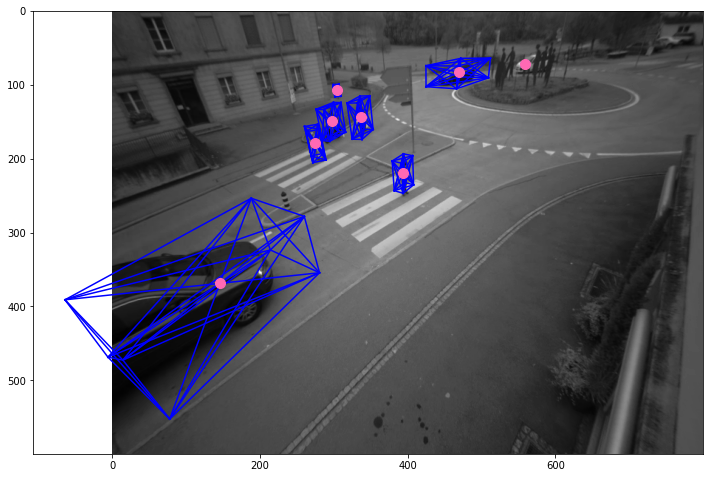

In [17]:
visualize_frame_boxes(f, 260, figsize = (12,12))

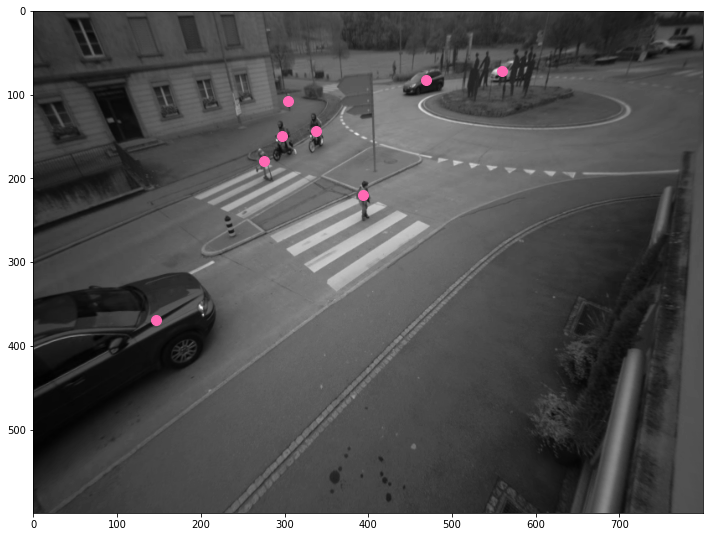

In [16]:
visualize_frame_detections(f,260, figsize = (12,12)) 